In [1]:
import warnings
warnings.filterwarnings('ignore')
import inspect
import logging
import os

import pandas as pd

from csrank.util import setup_logging, print_dictionary
from result_script import *
from csrank.experiments.constants import DCMS
from csrank.constants import DISCRETE_CHOICE
import numpy as np

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


/home/pritha/anaconda3/envs/linenv/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
DIR_PATH = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
FOLDER = "journalresults"
log_path = os.path.join(DIR_PATH, 'logs', 'results_dc.log')
latex_path = os.path.join(DIR_PATH, FOLDER, 'discrete_choice.tex')
df_path_combined = os.path.join(DIR_PATH, FOLDER , "DiscreteChoice.csv")

setup_logging(log_path=log_path, level=logging.ERROR)
logger = logging.getLogger('ResultParsing')
datasets = ['synthetic_dc', 'mnist_dc', 'tag_genome_dc', "letor_dc", "sushi_dc", "exp_dc"]
models = ['FETA-Net', 'FATE-Net', 'RankNetDC', 'LogitModel', 'NestedLogit', 'GenNestedLogit', 'PairedLogit', 'MixedLogit', 'PairwiseSVM', 'FATE-Linear','FETA-Linear', 'Baseline']
markers = ['o', '^', 'v', 'x', "*", '.', "+", "d","P", "8", "s", 'H']
models_dict = dict(zip(DCMS, models))
y_label="TopK"
x_label="Value of K"
fig_param = {'facecolor':'w', 'edgecolor':'w', 'transparent':False, 'dpi':800, 'format':'png','bbox_inches':'tight', 'pad_inches':0.05}
anotation = ['(a)', '(b)','(c)','(d)','(e)','(f)','(g)']
learning_problem = DISCRETE_CHOICE
learning_model = learners_map[learning_problem]

In [3]:
import re
def get_val(val):
    vals =  [float(x) for x in re.findall(r"[-+]?\d*\.\d+|\d+", val)]
    if len(vals)==1:
        x = [vals[0], vals[0]-0.0]
    else:
        x = [vals[0], vals[0] - vals[1]]
    return x
def create_final_result(dataset, dataset_function=get_combined_results ,latex_row=False):
    df_full = dataset_function(dataset, logger, learning_problem, latex_row=latex_row)
    data = []
    for dataset, df in df_full.groupby(['Dataset']):
        for m in DCMS:
            row = df[df[learning_model].str.contains(m)].values
            onerow = None
            if len(row) > 1:
                if dataset_function==get_combined_results:
                    values = np.array([get_val(val[2]) for val in row])
                else:
                    values = np.array([[val[2], val[2] - val[7]] for val in row])
                maxi = np.where(values[:,0] == values[:,0][np.argmax(values[:,0])])[0][0]
                logger.error("dataset {} model {}, vals {}, maxi {}".format(dataset, row[:, 1], values, maxi))
                row = row[maxi]
                row[1] = models_dict[m]
                onerow = row

            elif len(row)==1:
                row[0][1] = models_dict[m]
                onerow = row[0]
            if onerow is not None:
                onerow[0] = get_dataset_name(onerow[0])
                data.append(onerow)
    columns = df_full.columns
    dataframe = pd.DataFrame(data, columns=columns)
    dataframe = dataframe.sort_values(by=[columns[0], columns[2]], ascending=[True, False])
    return dataframe

In [4]:
d = datasets[5]
df = create_final_result(d)
df

,Dataset,DiscreteChoiceModel,CategoricalAccuracy,Top-2,Top-3,Top-4,Top-5
2,Expedia 10 Objects,RankNetDC,0.210±0.001,0.345±0.001,0.445±0.001,0.525±0.001,0.590±0.001
3,Expedia 10 Objects,LogitModel,0.199±0.004,0.326±0.005,0.423±0.005,0.501±0.005,0.565±0.004
6,Expedia 10 Objects,MixedLogit,0.181±0.010,0.308±0.011,0.407±0.010,0.485±0.008,0.551±0.007
7,Expedia 10 Objects,PairwiseSVM,0.179±0.001,0.305±0.001,0.405±0.001,0.484±0.000,0.550±0.000
4,Expedia 10 Objects,NestedLogit,0.171±0.007,0.292±0.008,0.388±0.008,0.468±0.008,0.534±0.008
1,Expedia 10 Objects,FATE-Net,0.157±0.030,0.266±0.048,0.355±0.055,0.430±0.058,0.496±0.058
8,Expedia 10 Objects,FATE-Linear,0.133±0.045,0.233±0.073,0.320±0.090,0.396±0.100,0.463±0.106
5,Expedia 10 Objects,GenNestedLogit,0.125±0.053,0.221±0.084,0.302±0.106,0.372±0.119,0.433±0.128
0,Expedia 10 Objects,FETA-Net,0.111±0.009,0.204±0.012,0.286±0.013,0.359±0.013,0.425±0.012
9,Expedia 10 Objects,FETA-Linear,0.058±0.017,0.112±0.032,0.165±0.045,0.215±0.057,0.265±0.069


In [5]:
df, cols = get_results_for_dataset(d, logger, learning_problem, False)
df = df.sort_values(by=['dataset', 'learner'], ascending=[True, True])
df = df[df['learner'].str.contains('feta_dc')]
#df = df[df['dataset'].str.contains('Hypervolume')]
df.head()

,job_id,dataset,learner,categoricalaccuracy,categoricaltopk2,categoricaltopk3,categoricaltopk4,categoricaltopk5,categoricaltopk6
49,533,Expedia_N_10,feta_dc_54de,0.0856,0.1655,0.2416,0.3149,0.3844,0.4462
76,598,Expedia_N_10,feta_dc_54de,0.0692,0.1349,0.1986,0.2599,0.3192,0.3740
75,638,Expedia_N_10,feta_dc_54de,0.0622,0.1195,0.1750,0.2294,0.2809,0.3284
33,354,Expedia_N_10,feta_dc_54de,0.0932,0.1758,0.2512,0.3207,0.3849,0.4407
17,570,Expedia_N_10,feta_dc_54de,0.1289,0.2302,0.3182,0.3975,0.4727,0.5376


In [12]:
df = get_combined_results(d, logger, learning_problem, False)
df

,Dataset,DiscreteChoiceModel,CategoricalAccuracy,Top-2,Top-3,Top-4,Top-5
0,Expedia_N_10,fate_dc_7699,0.157±0.030,0.266±0.048,0.355±0.055,0.430±0.058,0.496±0.058
1,Expedia_N_10,fatelinear_dc_6e6c,0.133±0.045,0.233±0.073,0.320±0.090,0.396±0.100,0.463±0.106
2,Expedia_N_10,feta_dc_54de,0.088±0.026,0.165±0.043,0.237±0.055,0.304±0.065,0.368±0.073
3,Expedia_N_10,feta_dc_zero_0309,0.111±0.009,0.204±0.012,0.286±0.013,0.359±0.013,0.425±0.012
4,Expedia_N_10,fetalinear_dc_ee68,0.058±0.017,0.112±0.032,0.165±0.045,0.215±0.057,0.265±0.069
5,Expedia_N_10,generalized_extreme_value_f43c,0.125±0.053,0.221±0.084,0.302±0.106,0.372±0.119,0.433±0.128
6,Expedia_N_10,mixed_logit_model_907e,0.181±0.010,0.308±0.011,0.407±0.010,0.485±0.008,0.551±0.007
7,Expedia_N_10,multinomial_logit_model_e293,0.199±0.004,0.326±0.005,0.423±0.005,0.501±0.005,0.565±0.004
8,Expedia_N_10,nested_logit_model_d5ac,0.171±0.007,0.292±0.008,0.388±0.008,0.468±0.008,0.534±0.008
9,Expedia_N_10,random_dc_089b,0.053±0.000,0.106±0.000,0.159±0.000,0.212±0.001,0.265±0.001


In [13]:
import copy
dataFrame = None
for dataset in datasets:
    df = create_final_result(dataset, latex_row=False)
    df_path = os.path.join(DIR_PATH, FOLDER , dataset.split('_dc')[0].title()+'DiscreteChoice.csv')
    df.to_csv(df_path, index=False, encoding='utf-8')
    if dataFrame is None:
        dataFrame = copy.copy(df)
    else:
        dataFrame = dataFrame.append(df, ignore_index=True)
dataFrame.to_csv(df_path_combined)
dataFrame.head()

,Dataset,DiscreteChoiceModel,CategoricalAccuracy,Top-2,Top-3,Top-4,Top-5
0,Medoid,FATE-Net,0.881±0.007,0.980±0.003,0.996±0.001,0.999±0.000,1.000±0.000
1,Medoid,FETA-Net,0.846±0.010,0.971±0.004,0.994±0.001,0.999±0.000,1.000±0.000
2,Medoid,RankNetDC,0.531±0.009,0.757±0.007,0.873±0.006,0.936±0.005,0.970±0.003
3,Medoid,PairedLogit,0.088±0.012,0.187±0.014,0.291±0.017,0.397±0.021,0.501±0.022
4,Medoid,NestedLogit,0.049±0.014,0.126±0.019,0.216±0.006,0.330±0.013,0.462±0.027


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
plt.style.use('default')
def get_max_min(maxi, mini, acc):
    if np.max(acc) > maxi:
        maxi = np.max(acc)
    if np.min(acc) < mini:
        mini = np.min(acc)
    return maxi, mini

def plot_group(grouped, plot_file, size, cols, a, b, maxi, mini, sharey=False, sharex = False, zoom=False):
    fig, axs = plt.subplots(a, b, figsize=size, sharey=sharey, sharex=sharex ,frameon=True, edgecolor='k', facecolor='white')
    fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
    fig.subplots_adjust(hspace=0)
    n_objects = 10
    for i, group in enumerate(grouped):
        zmini = 100
        zmaxi = -100
        name, group = group[0], group[1]
        if "N_5" in name:
            del group['categoricaltopk5']
            del group['categoricaltopk5se']
            n_objects = 5
        N_OBJECTS_ARRAY = np.arange(len(group.columns[2:])/2) + 1
        total = len(N_OBJECTS_ARRAY)
        dataFrame = group.set_index(learning_model).T
        try:
            if zoom:
                sub_plot, sub_plotz = axs[i][0], axs[i][1]
            else:
                sub_plot = axs[i]
        except Exception:
            if zoom:
                sub_plot, sub_plotz = axs
            else:
                sub_plot = axs
        j = 0
        for learner in models:
            if learner in list(dataFrame.columns):
                acc_se = dataFrame[learner].as_matrix()[1:]
                acc = acc_se[0:total]
                se = acc_se[total:]
                zmaxi, zmini = get_max_min(zmaxi, zmini, acc[0:2])
                sub_plot.errorbar(N_OBJECTS_ARRAY, acc, se, label=learner, marker=markers[j], linewidth=1)
                if zoom:
                    sub_plotz.plot(N_OBJECTS_ARRAY[0:2], acc[0:2], label=learner, marker=markers[j], linewidth=1)
                j = j+1
        
        acc = N_OBJECTS_ARRAY/n_objects
        #zmaxi, zmini = get_max_min(zmaxi, zmini, acc[0:2])
        if i == 0:
            sub_plot.set_ylabel(y_label)
            maxi, mini = get_max_min(maxi, mini, acc)
        sub_plot.set_yticks(np.arange(mini, maxi+0.1, 0.05))
        sub_plot.set_xticks(N_OBJECTS_ARRAY)
        sub_plot.set_xlabel(x_label)
        if zoom:
            #sub_plotz.plot(N_OBJECTS_ARRAY[0:2], acc[0:2], label='RANDOM', linewidth=1, color='k', marker='H')
            sub_plotz.set_xticks(N_OBJECTS_ARRAY[0:2])
            sub_plotz.set_yticks(np.arange(zmini, zmaxi, 0.1))
            sub_plotz.set_xlabel(x_label)
            title = "{} {}".format("Zoomed in ",name)
            sub_plotz.set_title(title, horizontalalignment='center', verticalalignment='bottom')
        title = "{} {}".format(anotation[i],name)
        sub_plot.set_title(title, horizontalalignment='center', verticalalignment='bottom')
    
    plt.legend(ncol=cols, fancybox=False, shadow=False, frameon=True, facecolor='white', edgecolor='k')
    fig_param['fname'] = plot_file
    plt.savefig(**fig_param)
    plt.tight_layout()
    plt.show()
def plot_graphs_for_dataset(DATASET):
    #plot_file = os.path.join(DIR_PATH, "detailedresults",'graphs', "{}{}.pdf".format(DATASET.split('_dc')[0], '{}'))
    plot_file = os.path.join(DIR_PATH, "thesis", "{}{}.pdf".format(DATASET.split('_dc')[0], '{}'))
    df = create_final_result(DATASET, dataset_function=get_combined_results_plot)
    grouped = df.groupby(['Dataset'])
    last = int(len(df.columns[2:])/2)
    maxi = np.around(np.max(df.as_matrix()[:,2:last+2]),2)
    mini = np.around(np.min(df.as_matrix()[:,2:last+2]),2)
    groups = np.array([group for group in grouped])
    i = 0
    if len(groups)in [2, 4]:
        a = 1
        b = 2
        size = (15,6)
    if len(groups) in [3,6]:
        a = 1
        b = 3
        size = (18,6)
    if len(groups)==1:
        a = 1
        b = 1
        size = (8,6)
    ns = int(len(grouped)/b)

    if ns == 1:
        ns = len(groups)
        plot_files = [plot_file.format('')]
    else:
        plot_files = [plot_file.format('_'+str(i)) for i in range(ns)]
    sharex = False
    sharey = False
    margin=0.05
    dict_inds = {'synthetic_dc':  [[1,2,0]], 'mnist_dc': [[0,1], [2,3]], 'tag_genome_dc':[[0,1, 5], [2,3, 4]], 
                 'letor_dc': [[1,3], [0,2]], 'sushi_dc':  [[0]], 'exp_dc': [[0,1]]}
    #inds = 
    zoom = False
    zoomf = False
    inds = dict_inds[DATASET]
    cols = 3
    for i, plot_file in enumerate(plot_files):
        if zoomf:
            if DATASET =='letor_dc':
                #sharex = True
                a = 2
                b = 2
                size = (15,12)
                zoom=True
            if DATASET =='sushi_dc':
                #sharex = True
                a = 1
                b = 2
                size = (15,6)
                zoom=True
        plot_group(groups[inds[i]], plot_file, size, cols, a, b, maxi, mini, sharey, sharex, zoom)

synthetic_dc


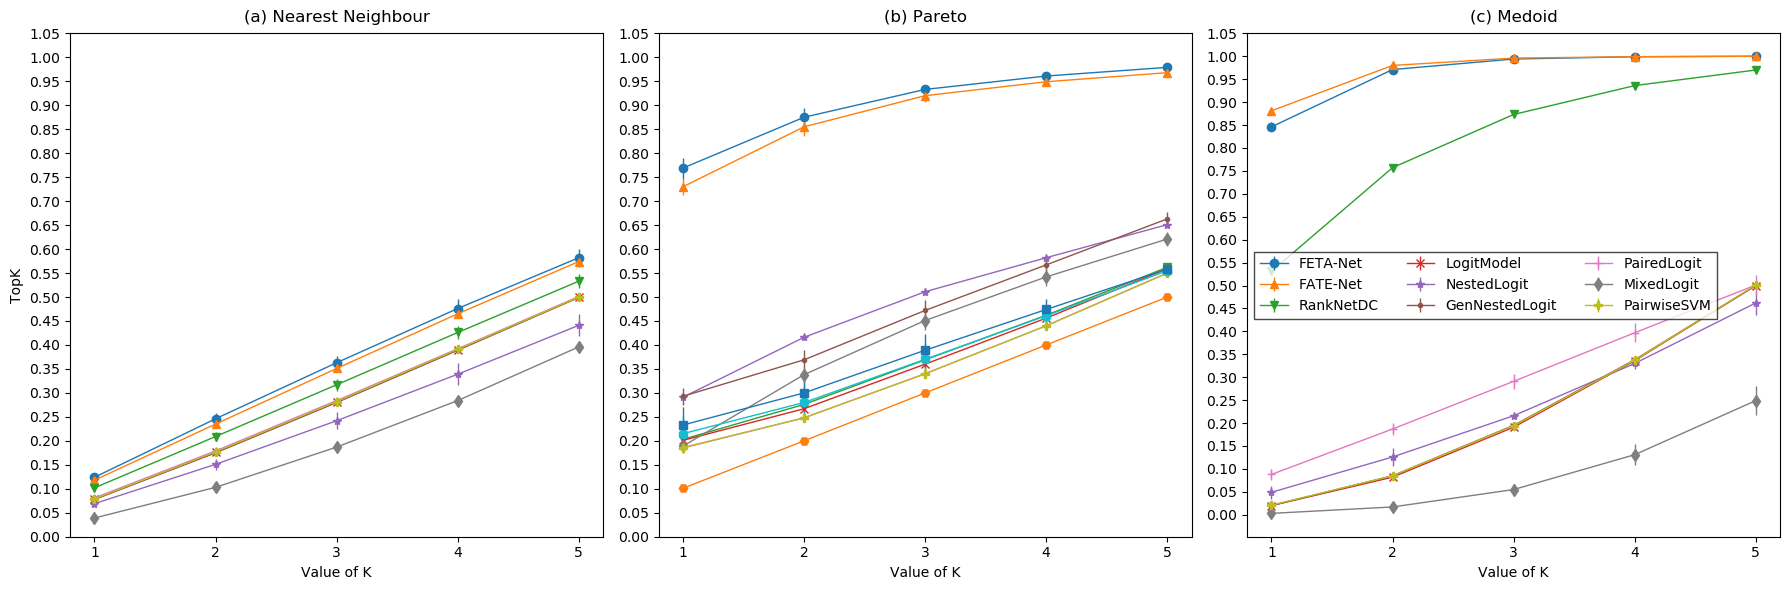

mnist_dc


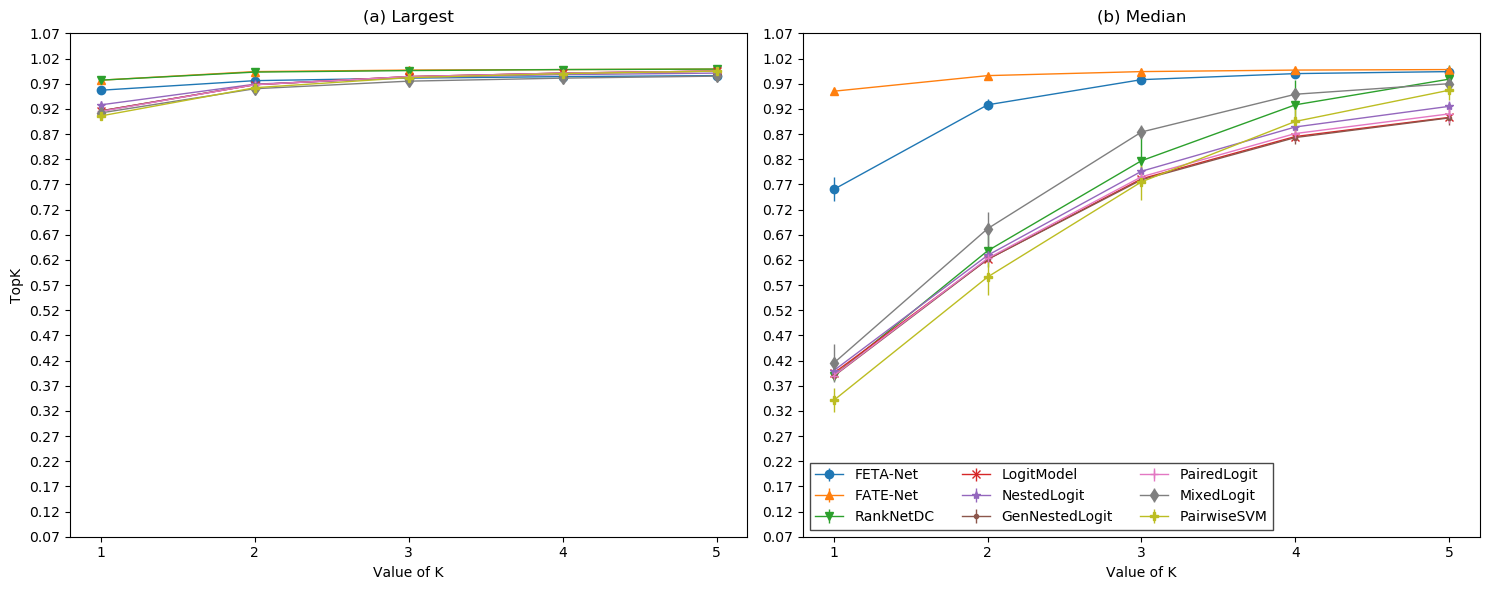

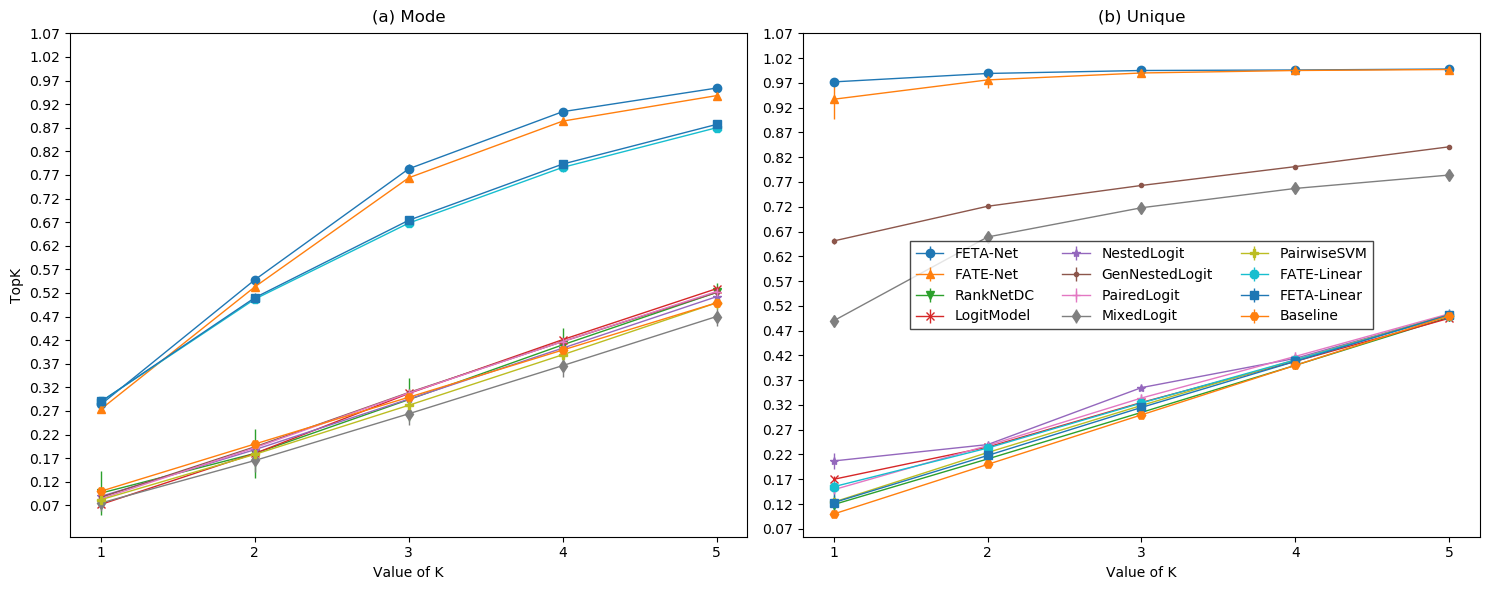

tag_genome_dc


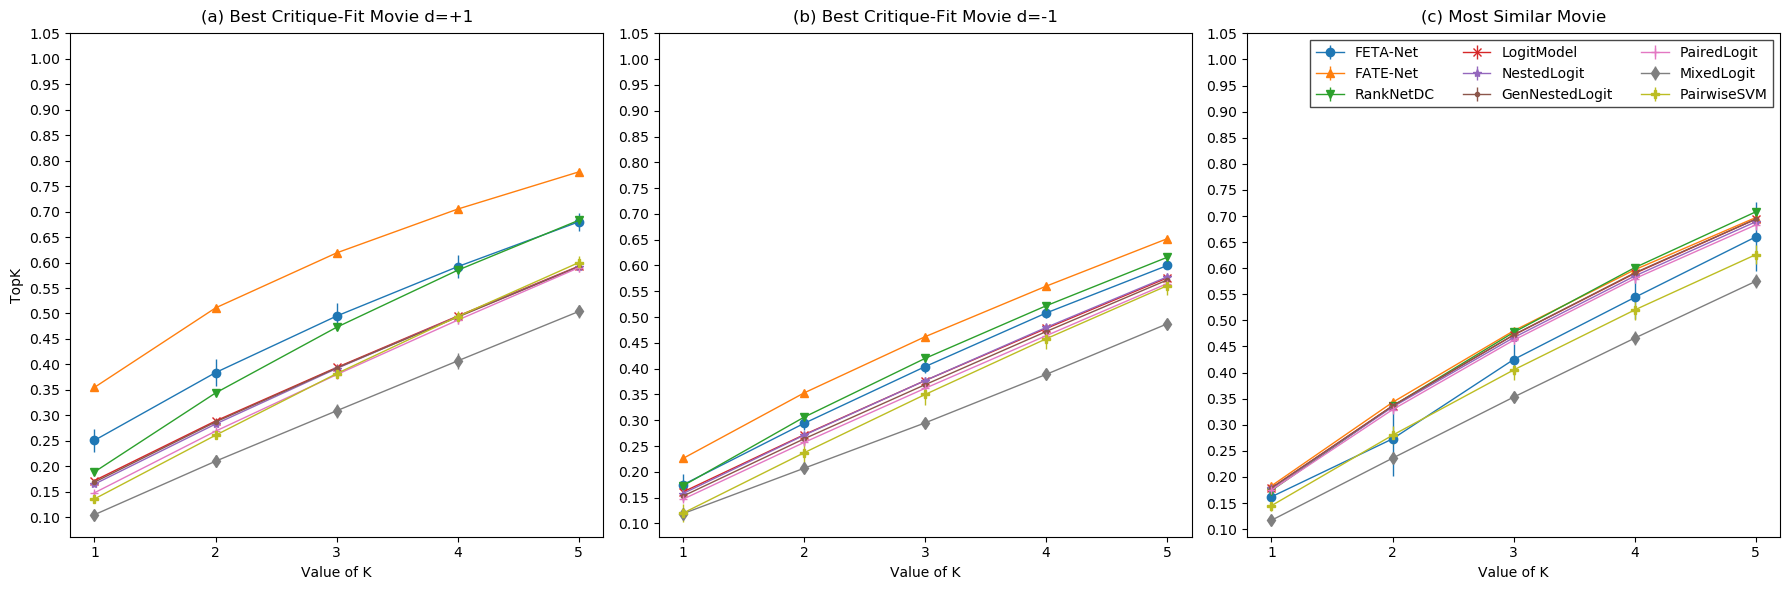

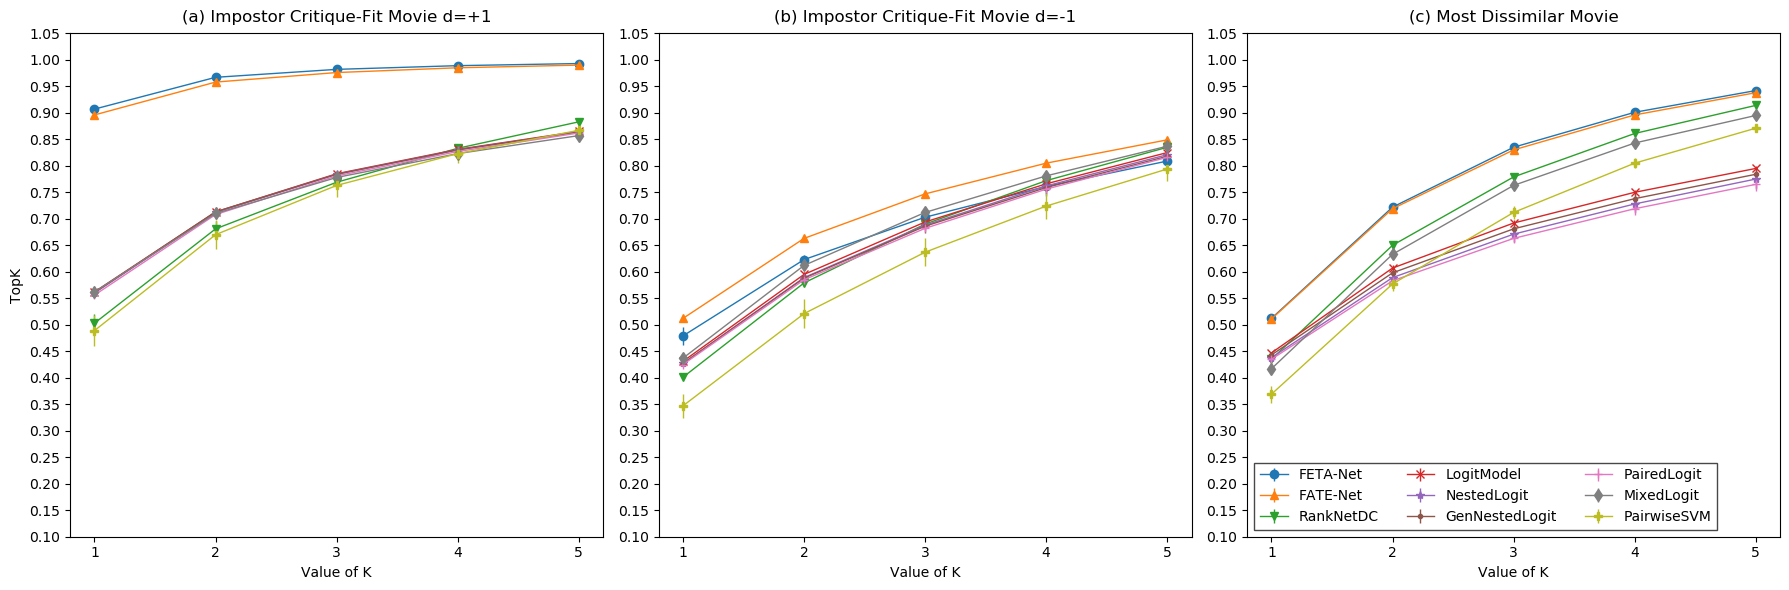

letor_dc


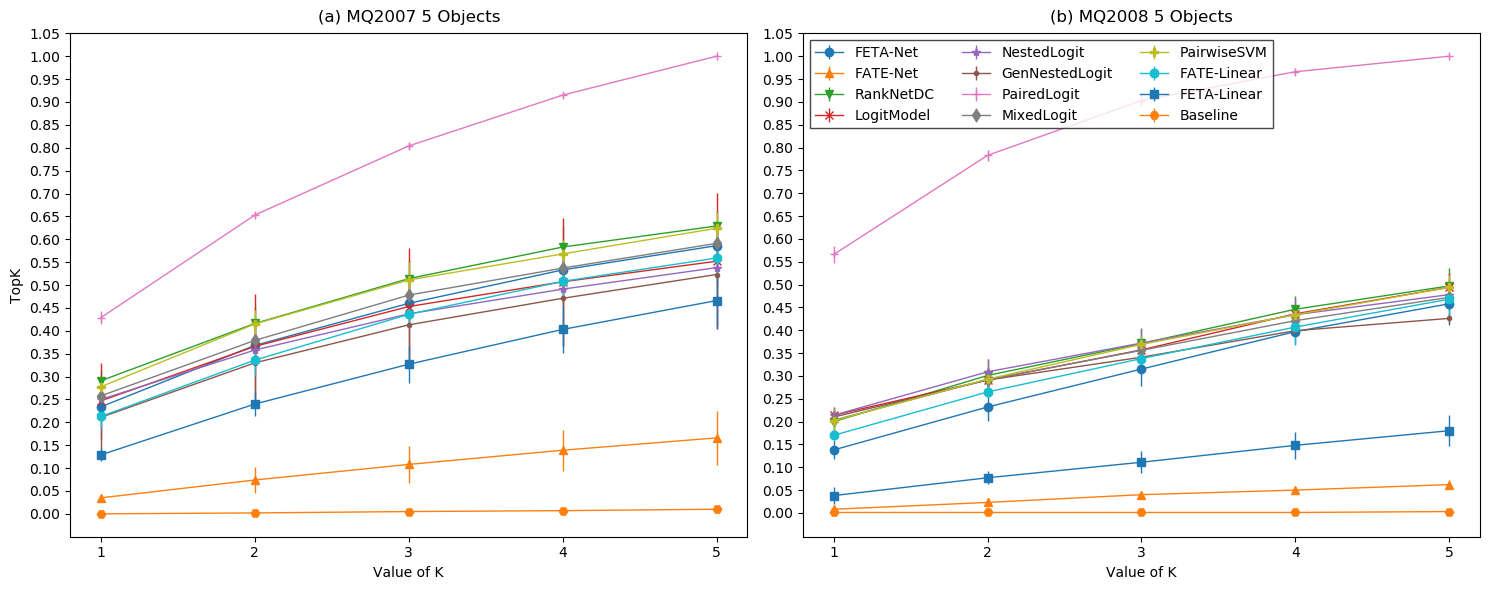

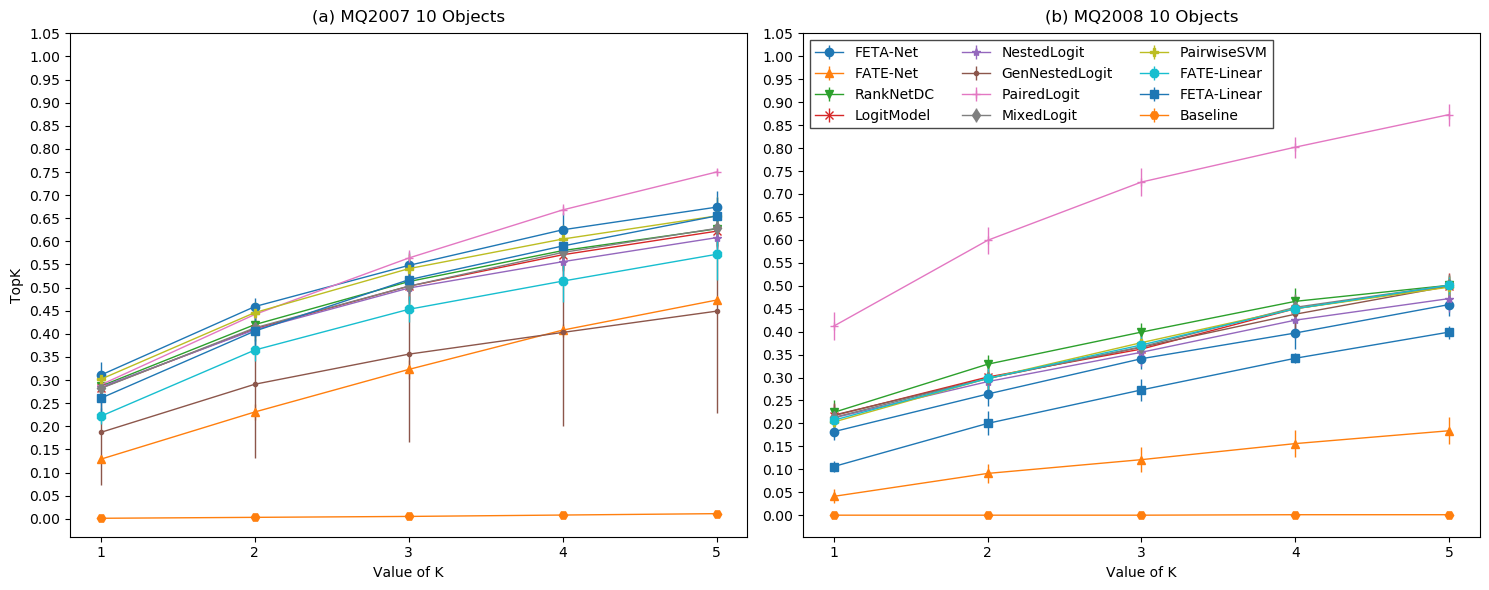

sushi_dc


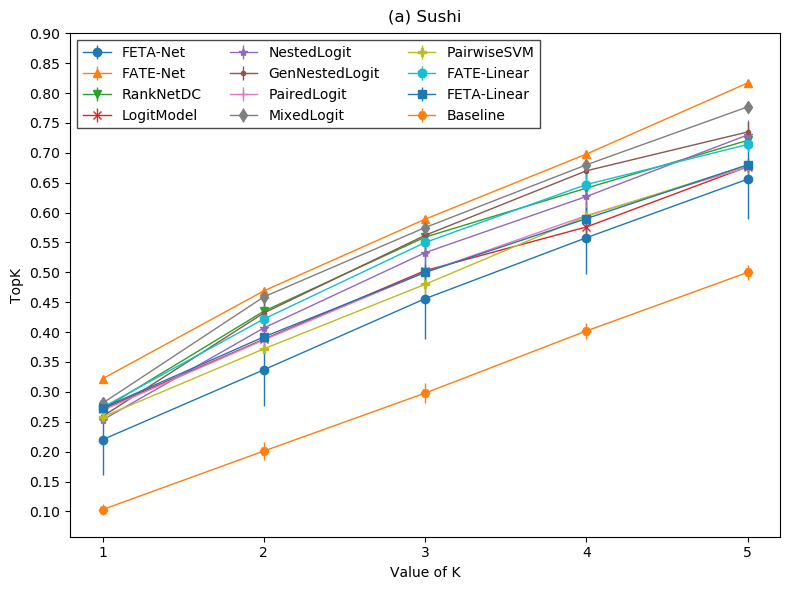

exp_dc


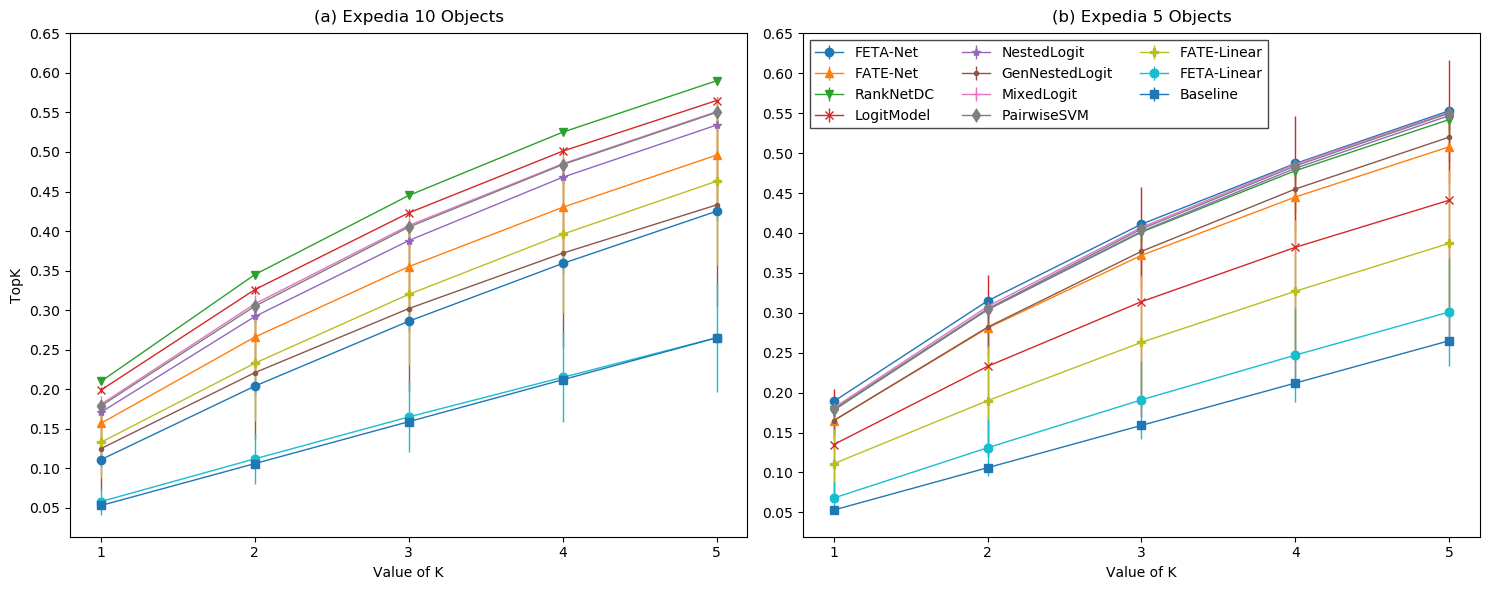

In [11]:
for dataset in datasets:
    print(dataset)
    plot_graphs_for_dataset(dataset)

In [14]:
def get_val(val):
    vals =  [float(x) for x in re.findall(r"[-+]?\d*\.\d+|\d+", val)]
    if len(vals)==1:
        x = [vals[0], vals[0]-0.0]
    else:
        x = [vals[0], vals[0] - vals[1]*1e-3]
    return x
def mark_best(df):
    for col in list(df.columns)[1:]:
        values_str = df[[learning_model,col]].as_matrix()
        values = np.array([get_val(val[1])for val in values_str])
        maxi = np.where(values[:,0] == values[:,0][np.argmax(values[:,0])])[0]
        for ind in maxi:
            values_str[ind] = [values_str[ind][0], "bfseries {}".format(values_str[ind][1])]
        df[learning_model] = values_str[:,0]
        df[col] = values_str[:,1]
    return df

In [15]:
import re
import string
def create_latex(df):
    grouped = df.groupby(['Dataset'])
    code = ""
    for name, group in grouped:
        
        custom_dict = {"PairwiseSVM":0, "RankNetDC":1, 'LogitModel':2, 'NestedLogit':3, 'GenNestedLogit':4, 
                       "MixedLogit":5, "FATE-Net":6, "FETA-Net":7, 'FATE-Linear':8,'FETA-Linear':9, 'Baseline':10}
        group['rank'] = group[learning_model].map(custom_dict)
        group.sort_values(by='rank', inplace=True)
        del group["Dataset"]
        del group['rank']
        group = mark_best(group)
        group[learning_model].replace(to_replace=['PairwiseSVM'], value='pairwisesvm',inplace=True)
        group[learning_model].replace(to_replace=['RankNetDC'], value='ranknetdc',inplace=True)
        group[learning_model].replace(to_replace=['LogitModel'], value='mnl',inplace=True)
        group[learning_model].replace(to_replace=['NestedLogit'], value='nlm',inplace=True)
        group[learning_model].replace(to_replace=['GenNestedLogit'], value='gnl',inplace=True)
        group[learning_model].replace(to_replace=['MixedLogit'], value='mlm',inplace=True)
        group[learning_model].replace(to_replace=['FATE-Net'], value='fatedc',inplace=True)
        group[learning_model].replace(to_replace=['FETA-Net'], value='fetadc',inplace=True)
        group[learning_model].replace(to_replace=['FATE-Linear'], value='fatelineardc',inplace=True)
        group[learning_model].replace(to_replace=['FETA-Linear'], value='fetalineardc',inplace=True)
        group[learning_model].replace(to_replace=['Baseline'], value='random',inplace=True)
        print("########## Name {}#################".format(name))
        code = code + "\n########## Name {}#################\n\n".format(name)
        if "N_5" in name:
            group = group.drop(columns='Top-5')
        latex_code = group.to_latex(index = False)
        latex_code = latex_code.replace(' ',"")
        latex_code = latex_code.replace('&'," & ")
        latex_code = str(latex_code)
        for learner in group[learning_model]:
            latex_code = latex_code.replace(learner, "\\{}".format(learner))
        latex_code = latex_code.replace("bfseries", "\\{} ".format("bfseries"))
        #latex_code = latex_code.replace("0.", ".")
        code = code + latex_code
    return code
code = ""
for dataset in datasets:
    df = create_final_result(dataset, latex_row=True)
    df.sort_values(by='Dataset')
    df = df[~df[learning_model].str.contains("PairedLogit")]
    code = code + create_latex(df)
f= open(latex_path,"w+")
f.write(code)
f.close()

########## Name Medoid#################
########## Name Nearest Neighbour#################
########## Name Pareto#################
########## Name Largest#################
########## Name Median#################
########## Name Mode#################
########## Name Unique#################
########## Name Best Critique-Fit Movie d=+1#################
########## Name Best Critique-Fit Movie d=-1#################
########## Name Impostor Critique-Fit Movie d=+1#################
########## Name Impostor Critique-Fit Movie d=-1#################
########## Name Most Dissimilar Movie#################
########## Name Most Similar Movie#################
########## Name MQ2007 10 Objects#################
########## Name MQ2007 5 Objects#################
########## Name MQ2008 10 Objects#################
########## Name MQ2008 5 Objects#################
########## Name Sushi#################
########## Name Expedia 10 Objects#################
########## Name Expedia 5 Objects#################


In [ ]:
config_file_path = os.path.join(DIR_PATH, 'config', 'clusterdb.json')
select_jobs = "SELECT * from {}.avail_jobs where learner='fatelinear_dc' and dataset='sushi_dc'".format(schema)
schema = 'discrete_choice'
learning_problem = DISCRETE_CHOICE
print(select_jobs)
self = DBConnector(config_file_path=config_file_path, is_gpu=False, schema=schema)
self.init_connection()
self.cursor_db.execute(select_jobs)
n_objects=10
job_ids=[]
for job in self.cursor_db.fetchall():
    if job['dataset_params'].get('n_objects', 10) == n_objects:
        job_ids.append(job['job_id'])
job_ids.sort()
print(job_ids)
self.close_connection()

In [ ]:
from copy import deepcopy
delete = False
job_ids2 = deepcopy(job_ids)
job_ids = []
cluster_id = 4256285
for job_id in job_ids2:
    print("*********************************************************************")
    select_re = "SELECT * from results.{} WHERE job_id={}".format(learning_problem, job_id)
    up = "DELETE FROM results.{} WHERE job_id={}".format(learning_problem, job_id)
    self.init_connection()
    self.cursor_db.execute(select_re)
    jobs_all = self.cursor_db.fetchall()[0]
    cluster_id = jobs_all[1]
    select_re = "SELECT * from {}.avail_jobs WHERE job_id={}".format(schema, job_id)
    self.cursor_db.execute(select_re)
    job = dict(self.cursor_db.fetchone())
    job = {k:v for k,v in job.items() if k in ["job_id","fold_id","learner_params","hash_value"]}
    print(print_dictionary(job))
    if jobs_all[2]<0.25:
        job_ids.append(job_id)
        if delete:
            self.cursor_db.execute(up)
    self.close_connection()
    print(jobs_all)
print(job_ids)

In [ ]:
if delete:
    values = np.array([0.2789, 0.4180, 0.5560, 0.6630, 0.7225, 0.7960])
    columns = ', '.join(list(lp_metric_dict[learning_problem].keys()))
    rs = np.random.RandomState(job_ids[0])
    for i, job_id in enumerate(job_ids):
        r = rs.uniform(-0.04,0.04,len(values)).round(3)
        print(r)
        vals = values + r
        print(vals)
        vals = "({}, {}, {})". format(job_id, cluster_id ,', '.join(str(x) for x in vals))
        update_result = "INSERT INTO results.{0} (job_id, cluster_id, {1}) VALUES {2}".format(learning_problem, columns, vals)
        self.init_connection()
        self.cursor_db.execute(update_result)
        self.close_connection()

In [ ]:
import re
def remove_ranker(sub_df):
    remove_ranker = None
    if len(sub_df)==2:
        sub_df = sub_df[:,1:3]
        val1 = [float(x) for x in re.findall(r"[-+]?\d*\.\d+|\d+", sub_df[0][1])]
        val2 = [float(x) for x in re.findall(r"[-+]?\d*\.\d+|\d+", sub_df[1][1])]
        val1 = val1[0] if len(val1)==1 else val1[0] - val1[1]*1e-3
        val2 = val2[0] if len(val2)==1 else val2[0] - val2[1]*1e-3
        if val1 < val2 :
            remove_ranker = sub_df[0][0]
        else:
            remove_ranker = sub_df[1][0]
    
    return remove_ranker

# Results for the Paper

In [ ]:
def get_results_for_dataset_2(del_jid = True):
    config_file_path = os.path.join(DIR_PATH, 'config', 'clusterdb.json')
    learning_problem = "discrete_choice"
    results_table = 'results.{}'.format(learning_problem)
    schema = 'discrete_choice'
    start = 3
    select_jobs = "SELECT learner_params, dataset_params, hp_ranges, {0}.job_id, dataset, learner, {2} from {0} INNER JOIN {1} ON {0}.job_id = {1}.job_id where {1}.dataset = ANY({3}) AND {1}.dataset_params->>\'dataset_type\'= ANY({4})"
    self = DBConnector(config_file_path=config_file_path, is_gpu=False, schema=schema)
    keys = list(lp_metric_dict[learning_problem].keys())
    keys[-1] = keys[-1].format(6)
    metrics = ', '.join([x for x in keys])
    #print(metrics)
    
    self.init_connection()
    avail_jobs = "{}.avail_jobs".format(self.schema)
    select_st = select_jobs.format(results_table, avail_jobs, metrics, "\'{synthetic_dc, mnist_dc}\'", "\'{hypervolume, unique, unique_max_occurring}\'")
    #print(select_st)
    self.cursor_db.execute(select_st)
    data = []
    for job in self.cursor_db.fetchall():
        job = dict(job)
        n_hidden = job['hp_ranges'].get("learner", {}).get("n_hidden", [])
        if job['hp_ranges'].get("learner", {}).get("n_hidden_set_layers", None)==[1,8]:
            job['learner'] = job['learner']+'_shallow'
        elif n_hidden==[1,4] or n_hidden==[1,5]:
            job['learner'] = job['learner']+'_shallow'

        if job['learner_params'].get("add_zeroth_order_model", False):
            job['learner'] = job['learner']+'_zero'
        if "letor" in job['dataset']:
            job['dataset'] = get_letor_string(job['dataset_params'])
        elif "sushi" in job['dataset']:
            job['dataset'] =  job['dataset']
        else:
            job['dataset'] = job['dataset_params']['dataset_type']
        job['learner'] = job['learner'].upper()
        job['dataset'] = job['dataset'].upper()
        values = list(job.values())
        keys = list(job.keys())
        columns = keys[start:]
        vals = values[start:]
        data.append(vals)
    
    self.init_connection()
    avail_jobs = "{}.avail_jobs".format("pymc3_discrete_choice")
    select_st = select_jobs.format(results_table, avail_jobs, metrics, "\'{synthetic_dc, mnist_dc}\'", "\'{hypervolume, unique, unique_max_occurring}\'")
    #print(select_st)
    self.cursor_db.execute(select_st)
    for job in self.cursor_db.fetchall():
        job = dict(job)
        if "letor" in job['dataset']:
            job['dataset'] = get_letor_string(job['dataset_params'])
        elif "sushi" in job['dataset']:
            job['dataset'] =  job['dataset']
        else:
            job['dataset'] = job['dataset_params']['dataset_type']
        job['learner'] = job['learner'].upper()
        job['dataset'] = job['dataset'].upper()
        values = list(job.values())
        keys = list(job.keys())
        columns = keys[start:]
        vals = values[start:]
        data.append(vals)
    df_full = pd.DataFrame(data, columns=columns)
    df_full = df_full.sort_values('dataset')
    if del_jid:
        del df_full['job_id']
    cols = list(df_full.columns)
    data = []
    dataf = []
    columns = []
    for c in cols:
        if 'categorical' in c:
            columns.append("{}se".format(c))
    columns = cols + columns
    for dataset, dgroup in df_full.groupby(['dataset']):
        max_feta = -100
        max_fate = -100
        max_ranknet = -100
        feta_r = []
        fate_r = []
        ranknet_r = []
        for learner, group in dgroup.groupby(['learner']):
            one_row = [dataset, learner]
            std = np.around(group.std(axis=0).values,3)
            mean = np.around(group.mean(axis=0).values,3)
            if np.all(np.isnan(std)):
                one_row.extend(["{:.4f}".format(m) for m in mean])
                #latex_row.extend(["${:.3f}$".format(m) for m in mean]) 
            else:
                std_err = [s for s in std]
                #std_err = [s/np.sqrt(len(group)) for s in std]
                one_row.extend([m for m in mean])
                one_row.extend([se for se in std_err])
                #one_row.extend(mean)
                #latex_row.extend(["$ {:.3f} \pm {:.3f} ".format(m, s) for m, s in zip(mean, std)])
            if "FETA_" in str(learner):
                if max_feta < mean[0] - std[0]:
                    max_feta = mean[0] - std[0]
                    feta_r = one_row
                    feta_r[1] = "FETA_DC"
            elif "FATE_" in str(learner):
                if max_feta < mean[0] - std[0]:
                    max_fate = mean[0] - std[0]
                    fate_r = one_row
                    fate_r[1] = "FATE_DC"
            elif "RANKNET_" in str(learner):
                if max_ranknet < mean[0] - std[0]:
                    max_ranknet = mean[0] - std[0]
                    ranknet_r = one_row
                    ranknet_r[1] = "RANKNET_DC"
            else:
                data.append(one_row)
        data.append(feta_r)
        data.append(ranknet_r)
        data.append(fate_r)
    df = pd.DataFrame(data, columns=columns)
    df.sort_values(by='dataset')
    del df['categoricaltopk6']
    del df['categoricaltopk6se']
    return df

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
plt.style.use('default')
def plot_group(grouped, plot_file, size, cols, a, b, maxi, mini, sharey=False, sharex = False, zoom=False):
    fig, axs = plt.subplots(a, b, figsize=size, sharey=sharey, sharex=sharex ,frameon=True, edgecolor='k', facecolor='white')
    fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
    fig.subplots_adjust(hspace=0)
    n_objects = 10
    for i, group in enumerate(grouped):
        zmini = 100
        zmaxi = -100
        name, group = group[0], group[1]
        if "N_5" in name:
            del group['categoricaltopk5']
            del group['categoricaltopk5se']
            n_objects = 5
        N_OBJECTS_ARRAY = np.arange(len(group.columns[2:])/2) + 1
        total = len(N_OBJECTS_ARRAY)
        dataFrame = group.set_index('learner').T
        try:
            if zoom:
                sub_plot, sub_plotz = axs[i][0], axs[i][1]
            else:
                sub_plot = axs[i]
        except Exception:
            if zoom:
                sub_plot, sub_plotz = axs
            else:
                sub_plot = axs
        j = 0
        for learner, model in zip(Dlower,models):
            if learner in list(dataFrame.columns):
                acc_se = dataFrame[learner].as_matrix()[1:]
                acc = acc_se[0:total]
                se = acc_se[total:]
                zmaxi, zmini = get_max_min(zmaxi, zmini, acc[0:2])
                sub_plot.errorbar(N_OBJECTS_ARRAY, acc, se, label=model, marker=markers[j], linewidth=1)
                if zoom:
                    sub_plotz.plot(N_OBJECTS_ARRAY[0:2], acc[0:2], label=model, marker=markers[j], linewidth=1)
                j = j+1
        
        #zmaxi, zmini = get_max_min(zmaxi, zmini, acc[0:2])
        if i == 0:
            sub_plot.set_ylabel(y_label)
            maxi, mini = get_max_min(maxi, mini, acc)
        sub_plot.set_yticks(np.arange(mini, maxi+0.1, 0.1))
        sub_plot.set_xticks(N_OBJECTS_ARRAY)
        sub_plot.set_xlabel(x_label)
        if zoom:
            #sub_plotz.plot(N_OBJECTS_ARRAY[0:2], acc[0:2], label='RANDOM', linewidth=1, color='k', marker='H')
            sub_plotz.set_xticks(N_OBJECTS_ARRAY[0:2])
            sub_plotz.set_yticks(np.arange(zmini, zmaxi, 0.1))
            sub_plotz.set_xlabel(x_label)
            title = "{} {}".format("Zoomed in ",get_name(name))
            sub_plotz.set_title(title, horizontalalignment='center', verticalalignment='bottom')
        title = "{} {}".format(anotation[i],get_name(name))
        sub_plot.set_title(title, horizontalalignment='center', verticalalignment='bottom')
    
    plt.legend(ncol=cols, fancybox=False, shadow=False, frameon=True, facecolor='white', edgecolor='k')
    fig_param['fname'] = plot_file
    plt.savefig(**fig_param)
    plt.tight_layout()
    plt.show()
plot_file = os.path.join(DIR_PATH, "thesis", "dc_results.pdf")
df = get_results_for_dataset_2()
df = df[df['learner']!='PAIRED_COMBINATORIAL_LOGIT']

last = int(len(df.columns[2:])/2)
maxi = 1.0 #np.around(np.max(df.as_matrix()[:,2:last+2]),2)
mini = 0.0 #np.around(np.min(df.as_matrix()[:,2:last+2]),2)
sharex = False
sharey = False
margin=0.05
grouped = df.groupby(['dataset'])
print(grouped)
groups = np.array([group for group in grouped])
groups = groups[[1,2,0]]
a = 1
b = 3
size = (18,5)
cols = 3
plot_group(groups, plot_file, size, cols, a, b, maxi, mini, sharey, sharex, False)

In [2]:
"UNIQUE_MAX_OCCURRING".lower()

'unique_max_occurring'